In [65]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

from __future__ import print_function, division

import numpy as np
import eos_integrate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", dpi=144)
import scipy.optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


rho_c:	 1.7e+15
p_c:	 7.2257113707e+35
R:	 12.5896493158
m_A:	 2.5865249291
mb_A:	 3.12006553653
alpha_A:	 0.0
phi_0:	 0.0


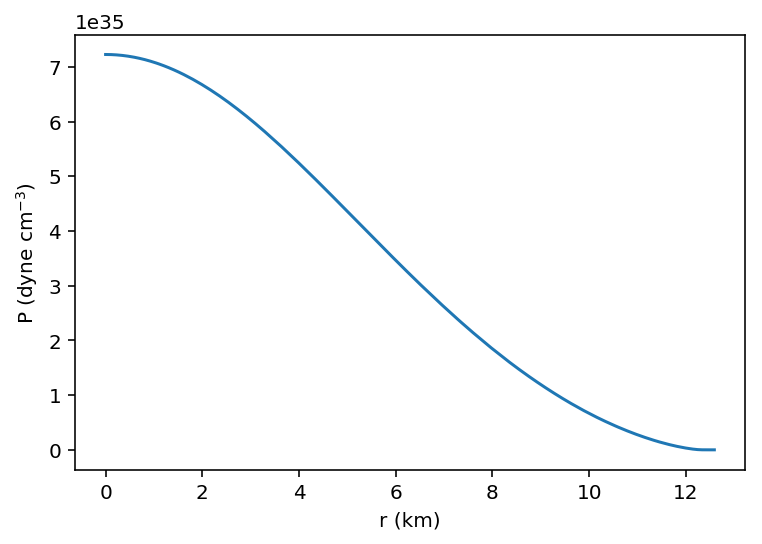

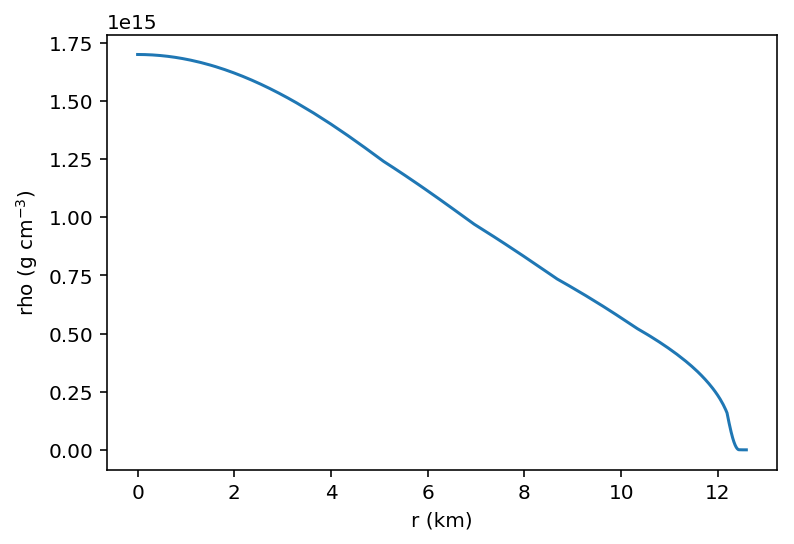

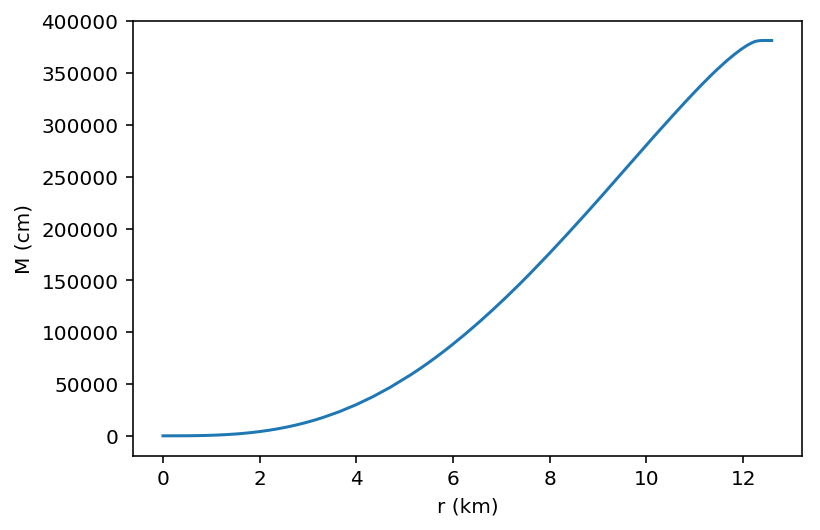

In [57]:
rho_c = 1.70e15
#rho_c = 0.76e15
#rho_c = 0.48e15
p_c = eos_integrate.lookup(
    eos_integrate.table_merged[:,1],
    eos_integrate.table_merged[:,2],
    rho_c)
print("rho_c:\t",rho_c)
print("p_c:\t",p_c)
N = eos_integrate.NeutronStar(a=0, b=0, rho_start=1e-6)
rs, xs = N.integrate(p_0 = p_c, phi_0 = 0)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
plt.figure()
plt.plot(rs/1e5, p)
plt.xlabel("r (km)")
plt.ylabel(r"P (dyne cm$^{-3}$)")

plt.figure()
rho = np.array([N.energy_density(pi) for pi in p])
plt.plot(rs/1e5, rho/3e10**2)
plt.xlabel("r (km)")
plt.ylabel(r"rho (g cm$^{-3}$)")

plt.figure()
plt.plot(rs/1e5, M)
plt.xlabel("r (km)")
plt.ylabel(r"M (cm)")

print("R:\t", N.R)
print("m_A:\t", N.m_A)
print("mb_A:\t", N.mb_A)
print("alpha_A:\t",N.alpha_A)
print("phi_0:\t",N.phi_0)

In [62]:
Rs = []
Ms = []
for rho_c in np.linspace(0.25e15,1.70e15,100):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)
    N = eos_integrate.NeutronStar(a=0, b=0, rho_start=1e-6)
    N.integrate(p_0 = p_c, phi_0 = 0)
    Rs.append(N.R)
    Ms.append(N.m_A)

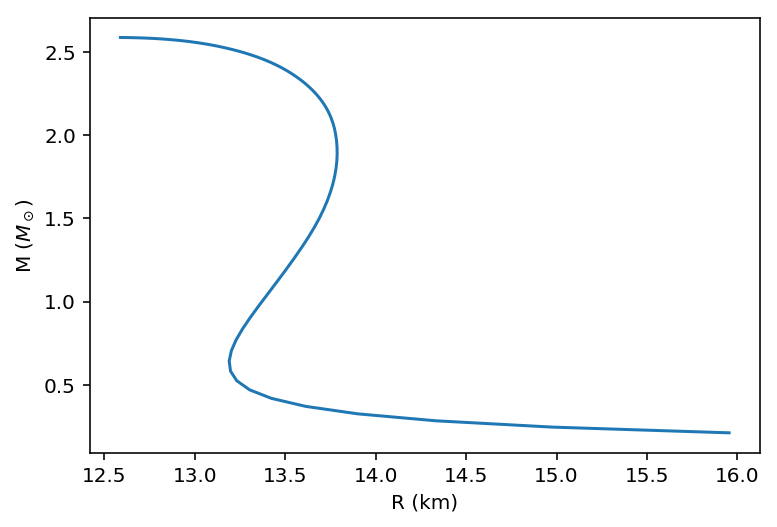

In [127]:
plt.plot(Rs,Ms)
plt.xlabel("R (km)")
plt.ylabel("M ($M_\odot$)")
plt.savefig("MR-GR.pdf")

rho_c:	 7.6e+14
p_c:	 1.50453980681e+35
R:	 13.7687276451
m_A:	 2.06384848722
mb_A:	 2.37116379906
alpha_A:	 -0.0141204532523
alpha_0:	 -0.00785490142959
beta_0:	 -3
phi_0:	 0.00261830047653
Delta:	 4.92152919691e-05


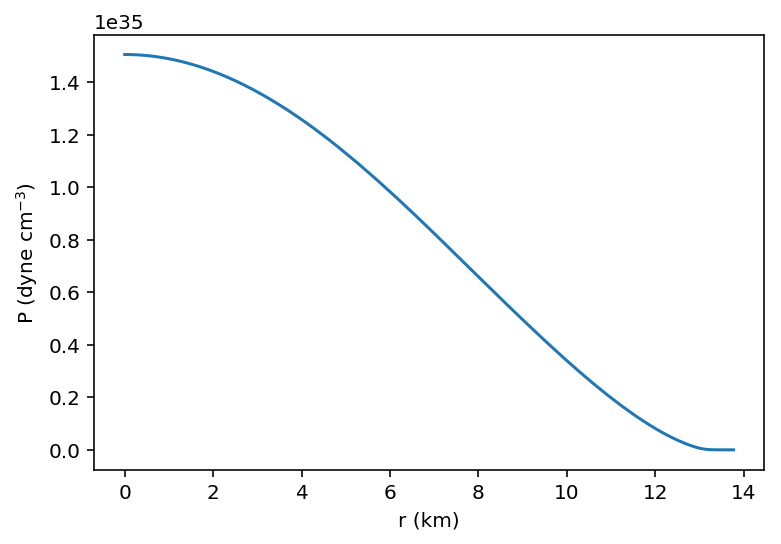

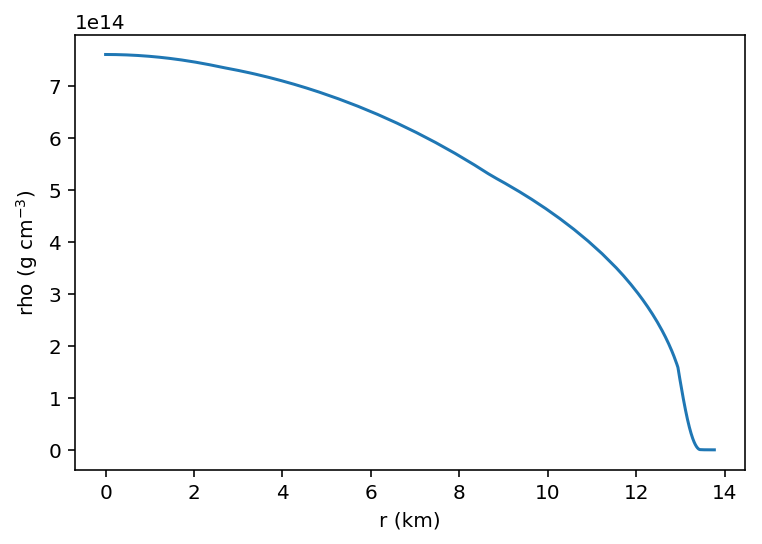

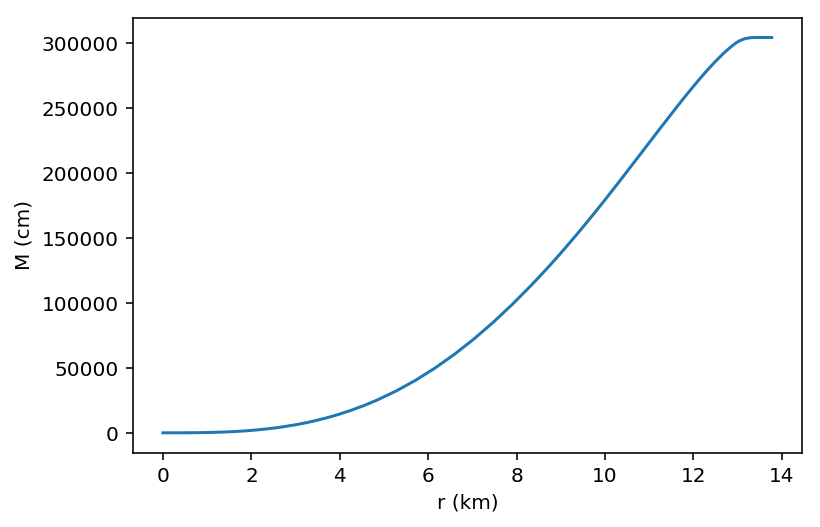

In [112]:
phi_c = 1e-2
#rho_c = 1.70e15
rho_c = 0.76e15
#rho_c = 0.48e15
p_c = eos_integrate.lookup(
    eos_integrate.table_merged[:,1],
    eos_integrate.table_merged[:,2],
    rho_c)
print("rho_c:\t",rho_c)
print("p_c:\t",p_c)
N = eos_integrate.NeutronStar(a=0, b=-3, rho_start=1e-6)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
plt.figure()
plt.plot(rs/1e5, p)
plt.xlabel("r (km)")
plt.ylabel(r"P (dyne cm$^{-3}$)")

plt.figure()
rho = np.array([N.energy_density(pi) for pi in p])
plt.plot(rs/1e5, rho/3e10**2)
plt.xlabel("r (km)")
plt.ylabel(r"rho (g cm$^{-3}$)")

plt.figure()
plt.plot(rs/1e5, M)
plt.xlabel("r (km)")
plt.ylabel(r"M (cm)")

print("R:\t", N.R)
print("m_A:\t", N.m_A)
print("mb_A:\t", N.mb_A)
print("alpha_A:\t",N.alpha_A)
print("alpha_0:\t",N.alpha_0)
print("beta_0:\t",N.beta_0)
print("phi_0:\t",N.phi_0)
print("Delta:\t",N.Delta)

## Equation of state

The idea is to use the same EOS as in the 0348 paper; this is a very old equation of state but it's also stiff enough to allow 2.7 M_sun neutron stars, so it's a fairly conservative choice. Annoyingly, it's based on a tabulated EOS for high density, another for low density, and then supposedly on a third for intermediate density - but using the intermediate equation the way they claim to leads to discontinuities and non-monotonicity. I'm just going to ignore the intermediate bit.

In [34]:
baym_table_scan = """
     1.044E4      9.744E18  6.295E27  26     56    1.796
     2.622E4      4.968E19  1.581E28  26     56    1.744
     6.587E4      2.431E20  3.972E28  26     56    1.706
     1.654E5      1.151E21  9.976E28  26     56    1.670
     4.156E5      5.266E21  2.506E29  26     56    1.631
     1.044E6      2.318E22  6.294E29  26     56    1.586
     2.622E6      9.755E22  1.581E30  26     56    1.534
     6.588E6      3.911E23  3.972E30  26     56    1.482
     8.293E6      5.259E23  5.000E30  28     62    1.471
     1.655E7      1.435E24  9.976E30  28     62    1.437
     3.302E7      3.833E24  1.990E31  28     62    1.408
     6.589E7      1.006E25  3.972E31  28     62    1.386
     1.315E8      2.604E25  7.924E31  28     62    1.369
     2.624E8      6.676E25  1.581E32  28     62    1.357
     3.304E8      8.738E25  1.990E32  28     64    1.355
     5.237E8      1.629E26  3.155E32  28     64    1.350
     8.301E8      3.029E26  5.000E32  28     64    1.346
     1.045E9      4.129E26  6.294E32  28     64    1.344
     1.316E9      5.036E26  7.924E32  34     84    1.343
     1.657E9      6.860E26  9.976E32  34     84    1.342
     2.626E9      1.272E27  1.581E33  34     84    1.340
     4.164E9      2.356E27  2.506E33  34     84    1.338
     6.601E9      4.362E27  3.972E33  34     84    1.337
     8.312E9      5.662E27  5.000E33  32     82    1.336
     1.046E10     7.702E27  6.294E33  32     82    1.336
     1.318E10     1.048E28  7.924E33  32     82    1.336
     1.659E10     1.425E28  9.976E33  32     82    1.335
     2.090E10     1.938E28  1.256E34  32     82    1.335
     2.631E10     2.503E28  1.581E34  30     80    1.335
     3.313E10     3.404E28  1.990E34  30     80    1.335
     4.172E10     4.628E28  2.506E34  30     80    1.334
     5.254E10     5.949E28  3.155E34  28     78    1.334
     6.617E10     8.089E28  3.972E34  28     78    1.334
     8.332E10     1.100E29  5.000E34  28     78    1.334
     1.049E11     1.495E29  6.294E34  28     78    1.334
     1.322E11     2.033E29  7.924E34  28     78    1.334
     1.664E11     2.597E29  9.976E34  26     76    1.334
     1.844E11     2.892E29  1.105E35  42     124   1.334
     2.096E11     3.290E29  1.256E35  40     122   1.334
     2.640E11     4.473E29  1.581E35  40     122   1.334
     3.325E11     5.816E29  1.990E35  38     120   1.334
     4.188E11      7.538E29 2.506E35  36     118   1.334
     4.299E11      7.805E29 2.572E35  36     118   1.334
                    4.460E11       7.890E29 2.670E35   40     126   0.40

                     5.228E11       8.352E29 3.126E35   40     128   0.36

                     6.610E11       9.098E29 3.951E35   40     130   0.40

                     7.964E11       9.831E29 4.759E35   41     132   0.46

                     9.728E11       1.083E30 5.812E35   41     135   0.54

                     1.196E12       1.218E30 7.143E35   42     137   0.63

                     1.471E12       1.399E30 8.786E35   42     140   0.73

                     1.805E12       1.638E30 1.077E36   43     142   0.83

                     2.202E12       1.950E30 1.314E36   43     146   0.93

                     2.930E12       2.592E30 1.748E36   44     151   1.06

                     3.833E12       3.506E30 2.287E36   45     156   1.17

                     4.933E12       4.771E30 2.942E36   46     163   1.25

                     6.248E12       6.481E30 3.726E36   48     170   1.31

                     7.801E12       8.748E30 4.650E36   49     178   1.36

                     9.611E12       1.170E31 5.728E36   50     186   1.39

                     1.246E13       1.695E31 7.424E36   52     200   1.43

                     1.496E13       2.209E31 8.907E36   54     211   1.44

                     1.778E13       2.848E31 1.059E37   56     223   1.46

                     2.210E13       3.931E31 1.315E37   58     241   1.47

                     2.988E13       6.178E31 1.777E37   63     275   1.49

                     3.767E13       8.774E31 2.239E37   67     311   1.51

                     5.081E13       1.386E32 3.017E37   74     375   1.53

                     6.193E13       1.882E32 3.675E37   79     435   1.54

                     7.732E13       2.662E32 4.585E37   88     529   1.56

                     9.826E13       3.897E32 5.821E37   100    683   1.60

                     1.262E14       5.861E32 7.468E37   117    947   1.65

                     1.586E14       8.595E32 9.371E37   143   1390   1.70

                     2.004E14       1.286E33 1.182E38   201   2500   1.74

                     2.520E14       1.900E33 1.484E38                1.81

                     2.761E14       2.242E33 1.625E38                1.82

                     3.085E14       2.751E33 1.814E38                1.87

                     3.433E14       3.369E33 2.017E38                1.92

                     3.885E14       4.286E33 2.280E38                1.97

                     4.636E14       6.103E33 2.715E38                2.03

                     5.094E14       7.391E33 2.979E38                2.05
"""

In [35]:
t = []
for l in baym_table_scan.split("\n"):
    l = l.strip()
    if not l:
        continue
    rho, P, n = [float(v) for v in l.split()[:3]]
    n *= 1e-39  # convert to fm^{-3}
    t.append([n,rho,P])
    print("[%g, %g, %g]" % (n, rho, P))
t   

[6.295e-12, 10440, 9.744e+18]
[1.581e-11, 26220, 4.968e+19]
[3.972e-11, 65870, 2.431e+20]
[9.976e-11, 165400, 1.151e+21]
[2.506e-10, 415600, 5.266e+21]
[6.294e-10, 1.044e+06, 2.318e+22]
[1.581e-09, 2.622e+06, 9.755e+22]
[3.972e-09, 6.588e+06, 3.911e+23]
[5e-09, 8.293e+06, 5.259e+23]
[9.976e-09, 1.655e+07, 1.435e+24]
[1.99e-08, 3.302e+07, 3.833e+24]
[3.972e-08, 6.589e+07, 1.006e+25]
[7.924e-08, 1.315e+08, 2.604e+25]
[1.581e-07, 2.624e+08, 6.676e+25]
[1.99e-07, 3.304e+08, 8.738e+25]
[3.155e-07, 5.237e+08, 1.629e+26]
[5e-07, 8.301e+08, 3.029e+26]
[6.294e-07, 1.045e+09, 4.129e+26]
[7.924e-07, 1.316e+09, 5.036e+26]
[9.976e-07, 1.657e+09, 6.86e+26]
[1.581e-06, 2.626e+09, 1.272e+27]
[2.506e-06, 4.164e+09, 2.356e+27]
[3.972e-06, 6.601e+09, 4.362e+27]
[5e-06, 8.312e+09, 5.662e+27]
[6.294e-06, 1.046e+10, 7.702e+27]
[7.924e-06, 1.318e+10, 1.048e+28]
[9.976e-06, 1.659e+10, 1.425e+28]
[1.256e-05, 2.09e+10, 1.938e+28]
[1.581e-05, 2.631e+10, 2.503e+28]
[1.99e-05, 3.313e+10, 3.404e+28]
[2.506e-05, 4.1

[[6.294999999999999e-12, 10440.0, 9.744e+18],
 [1.5809999999999998e-11, 26220.0, 4.968e+19],
 [3.972e-11, 65870.0, 2.431e+20],
 [9.976e-11, 165400.0, 1.151e+21],
 [2.506e-10, 415600.0, 5.266e+21],
 [6.293999999999999e-10, 1044000.0, 2.318e+22],
 [1.5809999999999998e-09, 2622000.0, 9.755e+22],
 [3.972e-09, 6588000.0, 3.911e+23],
 [4.999999999999999e-09, 8293000.0, 5.259e+23],
 [9.976e-09, 16550000.0, 1.435e+24],
 [1.99e-08, 33020000.0, 3.833e+24],
 [3.972e-08, 65890000.0, 1.006e+25],
 [7.923999999999999e-08, 131500000.0, 2.604e+25],
 [1.581e-07, 262400000.0, 6.676e+25],
 [1.99e-07, 330400000.0, 8.738e+25],
 [3.155e-07, 523700000.0, 1.629e+26],
 [5e-07, 830100000.0, 3.029e+26],
 [6.294e-07, 1045000000.0, 4.129e+26],
 [7.924e-07, 1316000000.0, 5.036e+26],
 [9.976e-07, 1657000000.0, 6.86e+26],
 [1.581e-06, 2626000000.0, 1.272e+27],
 [2.506e-06, 4164000000.0, 2.356e+27],
 [3.972e-06, 6601000000.0, 4.362e+27],
 [4.9999999999999996e-06, 8312000000.0, 5.662e+27],
 [6.293999999999999e-06, 10460

In [36]:
malone_table = [
    [0.1, 16.8, 1.52, 1.74],
    [0.15, 22.8, 2.29, 4.55],
]
t = []
for l in malone_table:
    n, _, e, P = l
    e *= 1e35
    P *= 1e33
    rho = e/3e10**2
    t.append([n, rho, P])
    print("    [%g, %g, %g]," % (n, rho, P))
t

    [0.1, 1.68889e+14, 1.74e+33],
    [0.15, 2.54444e+14, 4.55e+33],


[[0.1, 168888888888888.9, 1.7399999999999998e+33],
 [0.15, 254444444444444.44, 4.55e+33]]

(1e+32, 3e+34)

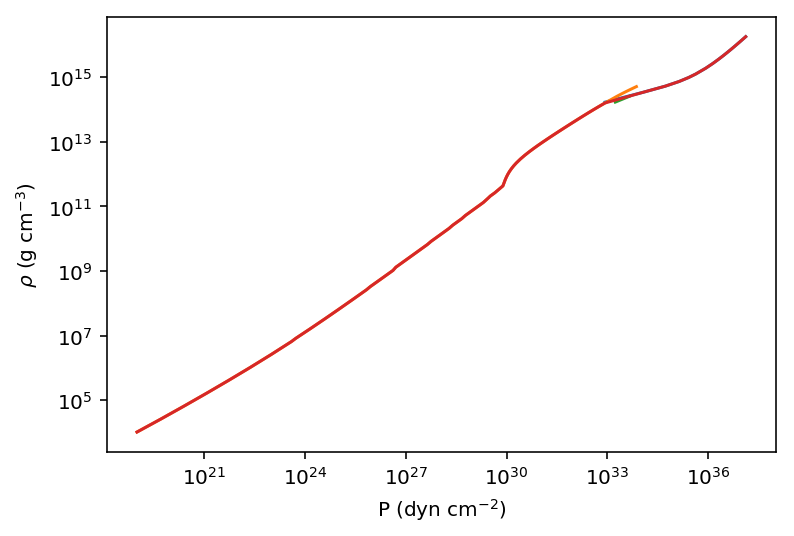

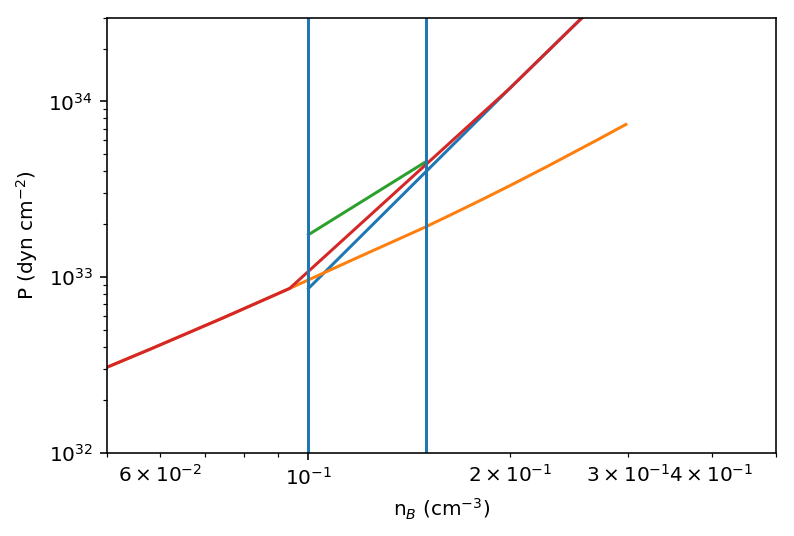

In [37]:

for t in [eos_integrate.table_20,
          eos_integrate.table_baym,
          eos_integrate.table_malone,
          eos_integrate.table_merged,
        ]:
    t = np.array(t)
    n, rho, P = t.T
    plt.figure(1)
    plt.loglog(P, rho)
    
    plt.figure(2)
    plt.loglog(n, P)
    
plt.figure(1)
plt.ylabel(r"$\rho$ (g cm$^{-3}$)")
plt.xlabel("P (dyn cm$^{-2}$)")

plt.figure(2)
plt.axvline(0.1)
plt.axvline(0.15)
plt.xlabel(r"n$_B$ (cm$^{-3}$)")
plt.ylabel("P (dyn cm$^{-2}$)")
plt.xlim(0.05,0.5)
plt.ylim(1e32,3e34)

(0, 1000000000000000.0)

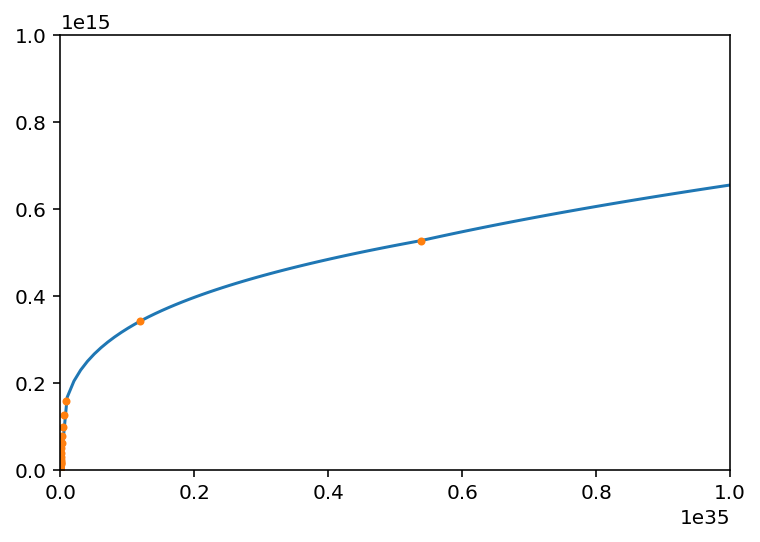

In [53]:
xs = np.linspace(0,1e35,100)
ys = [eos_integrate.eos_20_rho_p(x) for x in xs]
plt.plot(xs,ys)
plt.plot(eos_integrate.table_merged[:,2],
         eos_integrate.table_merged[:,1],
         ".")
plt.xlim(0,1e35)
plt.ylim(0,1e15)

## Exploring $\alpha$-$\beta$ space

We have a pulsar of known mass (${\sim}1.43 M_\odot$) and for each $\alpha_0$, $\beta_0$ we want to compute $\alpha_A$ and determine whether $\alpha_0(\alpha_A-\alpha_0)<\Delta_{max}$. But when we integrate an EOS we supply the central pressure, scalar value, and $\beta_0$, and we get out $\alpha_0$, $m_A$, and $\alpha_A$. So we have some root-finding to do. 
* Option 1: Use 2D root-finding to compute the right $\alpha_0$ for each $\beta_0$.
* Option 2: Build a database of pulsars on a grid of pressure, scalar value, and $\beta_0$. Then use interpolation to draw limit curves.
* Option 3: Use 1D root finding on the mass, then explore phi_0 values

Note that we have to do this for several different pulsar masses and constraint levels; at least 0348, 1738, and 0337. So Option 2 has some appeal. Particularly as we're not yet quite sure what our limit will be.

In [107]:
def f(x, beta_0):
    lp_c, lphi_c = x
    p_c = np.exp(lp_c)
    phi_c = np.exp(lphi_c)
    print(p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    res = np.array([m_A-1.43, alpha_0*(alpha_A-alpha_0)-1.6e-6])
    print(res)
    return res

r = scipy.optimize.root(
    f, 
    [np.log(0.76e15), np.log(1e-3)],
    args=(-3,),
    method="lm")

7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6000038804e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.00100000010293 -3
[ -1.42930227e+00  -1.60000028e-06]
inf 0.0 -3
[ nan  nan]
inf 0.0 -3
[ nan  nan]
4.47742327279e+74 0.0 -3
[ nan  nan]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.37180724396e+21 0.0 -3
[ -1.29965401e+00  -1.60000000e-06]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3


/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
eos_integrate.py:230: RuntimeWarning: invalid value encountered in double_scalars
  * a_phi*(e-3*p_c))
eos_integrate.py:203: RuntimeWarning: invalid value encountered in double_scalars
  * (a_phi*(e-3*p)+rho*psi*(e-p))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Illegal input detected. (See printed message.)
  'Unexpected istate=%s' % istate))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  'Unexpected istate=%s' % istate))
eos_integrate.py:243: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha_A = 2*phi/

[ -1.28990959e+00  -1.60000000e-06]
1.72524158948e+21 0.0 -3
[ -1.28990956e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3
[ -1.28990959e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
2.70984926657e+21 0.0 -3
[ -1.26905732e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
6.34411699958e+21 0.0 -3
[ -1.22263514e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.86472641683e+22 0.0 -3
[ -1.15010415e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
1.48322426261e+23 0.0 -3
[ -9.65739347e-01  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
7.19237449692e+23 0.0 -3
[ -8.08276594e-01  -1.60000000e-06]
7.19238038429e+23 0.0 -3
[ -8.08276948e-01  -1.6000

In [114]:
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

r = scipy.optimize.brentq(
    f, 
    0.1e15,1.7e15,
    args=(1e-3,-3))

In [115]:
r

553380926715902.0

In [ ]:
solutions = set()

In [124]:
last = None
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

def g(phi_c, beta_0):
    rho_c = scipy.optimize.brentq(
        f, 
        0.1e15,1.7e15,
        args=(phi_c,beta_0))
    d = eos_integrate.evaluate(rho_c, phi_c, beta_0)
    global last
    last = (rho_c, phi_c, beta_0)
    print(last, d["Delta"])
    return np.abs(d["Delta"]) - 4e-7

xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),100))
ys = []
for phi_c in xs:
    ys.append(g(phi_c,-3))

#phi_c = scipy.optimize.brentq(
#    g, 
#    0.1e-3,0.5,
#    args=(-3,))

#d = eos_integrate.evaluate(*last)
#d

(553380926882925.6, 0.0010000000000000002, -3) -1.49283119058e-12
(553381016890000.9, 0.00106478597782335, -3) -1.69253215601e-12
(553381100546195.8, 0.0011337691785692262, -3) -1.91894866798e-12
(553381221689049.5, 0.0012072215234288095, -3) -2.17565501475e-12
(553381347852073.7, 0.0012854325502735374, -3) -2.46670364015e-12
(553381497802855.7, 0.0013687105549689707, -3) -2.79668931853e-12
(553381688203902.44, 0.0014573838066297739, -3) -3.17082161428e-12
(553381853537977.25, 0.0015518018416061992, -3) -3.59500756245e-12
(553382034596566.2, 0.0016523368413027301, -3) -4.07594466688e-12
(553382240303320.4, 0.0017593850992600724, -3) -4.62122625405e-12
(553382458606341.6, 0.0018733685832834674, -3) -5.23946310646e-12
(553382723823358.2, 0.0019947365987750282, -3) -5.9404176523e-12
(553383027887903.4, 0.0021239675598266911, -3) -6.73516011469e-12
(553383372472591.56, 0.0022615708750551352, -3) -7.63624236397e-12
(553383767164943.1, 0.0024080889556123909, -3) -8.65789727913e-12
(553384232

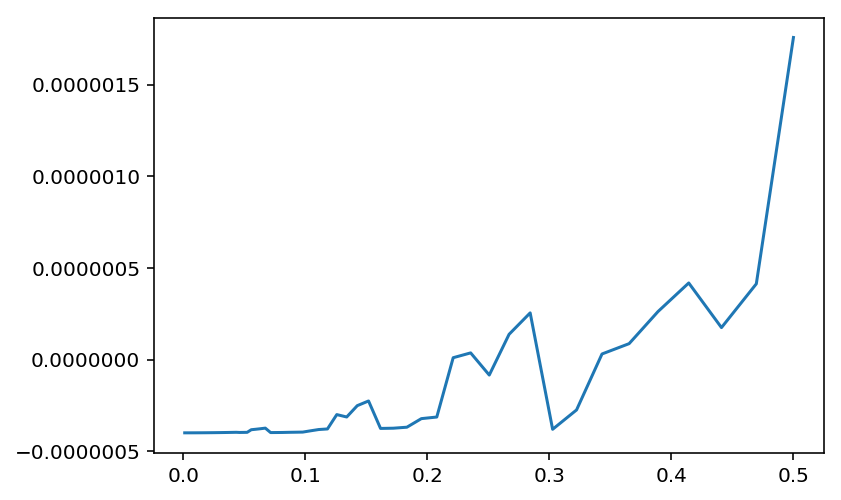

In [125]:
plt.plot(xs, ys)

In [128]:
l = []

In [129]:
l.insert?

In [149]:
points = []

In [150]:
eos_integrate.mr_curve(points, 0, 0, 1.43)

{'Delta': 0.0,
 'I_A': 2.2530921759394333e+36,
 'J_A': 2.2530921806348049e+36,
 'Omega': 1.0000000020839679,
 'Q1': 1.0,
 'Q2': 0.83131792872211197,
 'R': 13.652707150389318,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (6.204500705854884e+34, 0, 0),
 'm_A': 1.4299999999090507,
 'mb_A': 1.5663402707884728,
 'nu_hat': -0.369485943174853,
 'nu_prime': 3.2740070019246783e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [151]:
len(points)

71

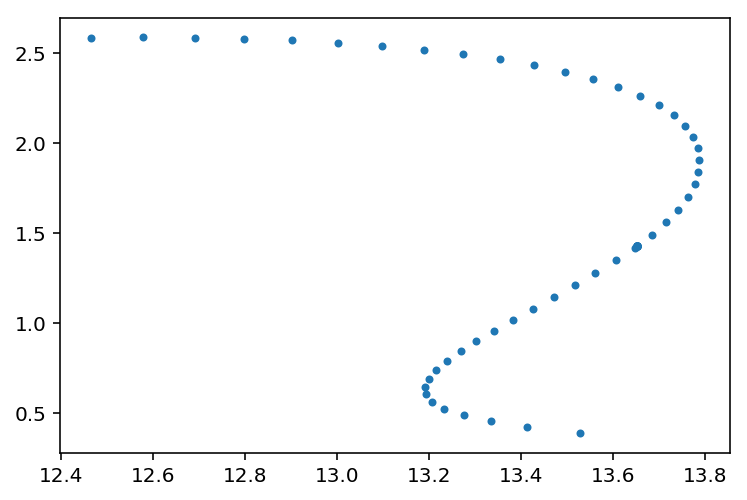

In [152]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")